<a href="https://colab.research.google.com/github/AngelGuadarrama/Cross-Selling/blob/main/Cross_Sale_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ML Classification Assignment

We want to know if a client that has subscribed a health insurance could be interested in a vehicle insurance

## **Importing Data**

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import  RandomForestClassifier
#from sklearn.svm import SVC
import xgboost as xgb 
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split


data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cross_Sale_Classification/model.csv')
data.head()

,id,Gender,Age,Driving_License,Licence_Type,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Seniority,Target
0,1,Female,44,1,M,30,No,1-2 Year,Yes,25741,154,152,0
1,2,Male,23,1,M,3,Yes,< 1 Year,No,2630,152,256,0
2,3,Male,43,1,C,28,No,1-2 Year,Yes,70720,52,224,0
3,4,Male,60,1,B,28,Yes,1-2 Year,No,48512,26,86,0
4,5,Female,42,1,B,46,No,1-2 Year,Yes,32169,124,132,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102351 entries, 0 to 102350
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    102351 non-null  int64 
 1   Gender                102351 non-null  object
 2   Age                   102351 non-null  int64 
 3   Driving_License       102351 non-null  int64 
 4   Licence_Type          97260 non-null   object
 5   Region_Code           102351 non-null  int64 
 6   Previously_Insured    102351 non-null  object
 7   Vehicle_Age           102351 non-null  object
 8   Vehicle_Damage        102351 non-null  object
 9   Annual_Premium        102351 non-null  int64 
 10  Policy_Sales_Channel  102351 non-null  int64 
 11  Seniority             102351 non-null  int64 
 12  Target                102351 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 10.2+ MB


## **Cleaning Data**



*   The License_Type column has null values that we are going to convert to another category because these rows also have False in the Driving_License column (those who don't have a driver's license)



In [ ]:
data.Driving_License.value_counts()

1    97260
0     5091
Name: Driving_License, dtype: int64

In [2]:
data.fillna({'Licence_Type':'N'}, inplace=True)
data.Licence_Type.value_counts()

C    19835
M    19686
D    19566
B    19306
A    18867
N     5091
Name: Licence_Type, dtype: int64

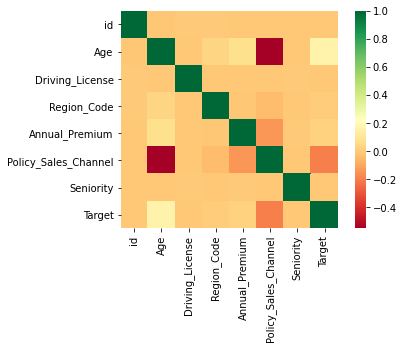

In [ ]:
sns.heatmap(data.corr(), square= True, cmap='RdYlGn')


*  Let's change the data type restrictions

In [3]:
data['Previously_Insured'].replace({'Yes':'True','No':'False'}, inplace=True)
data['Vehicle_Damage'].replace({'Yes':'True','No':'False'}, inplace=True)

labels_multi=['Gender','Licence_Type','Vehicle_Age']
labels_bin=['Driving_License','Previously_Insured','Vehicle_Damage']

data[labels_multi]=data[labels_multi].apply(lambda x: x.astype('category') ,axis=0)
data[labels_bin]=data[labels_bin].apply(lambda x: x.astype('bool') ,axis=0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102351 entries, 0 to 102350
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    102351 non-null  int64   
 1   Gender                102351 non-null  category
 2   Age                   102351 non-null  int64   
 3   Driving_License       102351 non-null  bool    
 4   Licence_Type          102351 non-null  category
 5   Region_Code           102351 non-null  int64   
 6   Previously_Insured    102351 non-null  bool    
 7   Vehicle_Age           102351 non-null  category
 8   Vehicle_Damage        102351 non-null  bool    
 9   Annual_Premium        102351 non-null  int64   
 10  Policy_Sales_Channel  102351 non-null  int64   
 11  Seniority             102351 non-null  int64   
 12  Target                102351 non-null  int64   
dtypes: bool(3), category(3), int64(7)
memory usage: 6.1 MB


## **Split categorical/continuous**

In [4]:
data_categorical=data[['Gender', 'Driving_License', 'Licence_Type', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
       'Policy_Sales_Channel', 'Target']]
data_numerical=data[['id','Age', 'Annual_Premium', 'Seniority']]

## **Categorical variables**


In [ ]:
data_categorical.columns

Index(['Region_Code', 'Policy_Sales_Channel', 'Target', 'Driving_License_enc',
       'Previously_Insured_enc', 'Vehicle_Damage_enc', 'DM_Male', 'DM_B',
       'DM_C', 'DM_D', 'DM_M', 'DM_N', 'DM_< 1 Year', 'DM_> 2 Years'],
      dtype='object')

In [ ]:
data_categorical.Target.value_counts()

0    69878
1    32473
Name: Target, dtype: int64

In [5]:
enc1=LabelEncoder()
enc2=LabelEncoder()
enc3=LabelEncoder()

enc1.fit(data_categorical.Driving_License)
enc2.fit(data_categorical.Previously_Insured)
enc3.fit(data_categorical.Vehicle_Damage)

data_categorical['Driving_License_enc']=enc1.transform(data_categorical.Driving_License)
data_categorical['Previously_Insured_enc']=enc2.transform(data_categorical.Previously_Insured)
data_categorical['Vehicle_Damage_enc']=enc3.transform(data_categorical.Vehicle_Damage)

data_categorical.drop(['Driving_License','Previously_Insured','Vehicle_Damage'], axis=1, inplace=True)

data_categorical=pd.get_dummies(data_categorical, columns=['Gender', 'Licence_Type', 'Vehicle_Age'], drop_first=True, prefix='DM')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
data_categorical.columns

Index(['Region_Code', 'Policy_Sales_Channel', 'Target', 'Driving_License_enc',
       'Previously_Insured_enc', 'Vehicle_Damage_enc', 'DM_Male', 'DM_B',
       'DM_C', 'DM_D', 'DM_M', 'DM_N', 'DM_< 1 Year', 'DM_> 2 Years'],
      dtype='object')

## **Numerical variables**

In [ ]:
data_numerical[['Age', 'Annual_Premium', 'Seniority']].describe()

,Age,Annual_Premium,Seniority
count,102351.000000,102351.000000,102351.000000
mean,39.867339,30748.636398,154.527030
std,14.935793,17544.726810,83.735221
min,20.000000,2630.000000,10.000000
25%,25.000000,24435.500000,82.000000
50%,39.000000,31943.000000,155.000000
75%,50.000000,39774.000000,227.000000
max,85.000000,540165.000000,299.000000


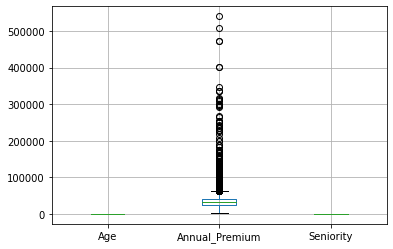

In [ ]:
data_numerical[['Age', 'Annual_Premium', 'Seniority']].boxplot()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


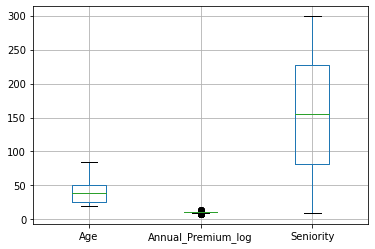

In [6]:
data_numerical['Annual_Premium_log']=np.log(data_numerical.Annual_Premium)

data_numerical[['Age', 'Annual_Premium_log', 'Seniority']].boxplot()
plt.show()

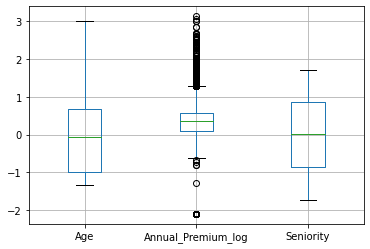

In [7]:
ss1=StandardScaler()
ss2=StandardScaler()
ss3=StandardScaler()

ss1.fit(data_numerical[['Age']])
ss2.fit(data_numerical[['Annual_Premium_log']])
ss3.fit(data_numerical[['Seniority']])

data_num_scaled=pd.concat([pd.DataFrame(ss1.transform(data_numerical[['Age']]), columns=['Age']), 
                           pd.DataFrame(ss2.transform(data_numerical[['Annual_Premium_log']]), columns=['Annual_Premium_log']), 
                           pd.DataFrame(ss3.transform(data_numerical[['Seniority']]), columns=['Seniority']) ], axis=1)

data_num_scaled.boxplot()
plt.show()

## **Joining the columns**

In [8]:
data_encoded=pd.concat([data_numerical.id, data_num_scaled, data_categorical], axis=1)
data_encoded.shape

(102351, 18)

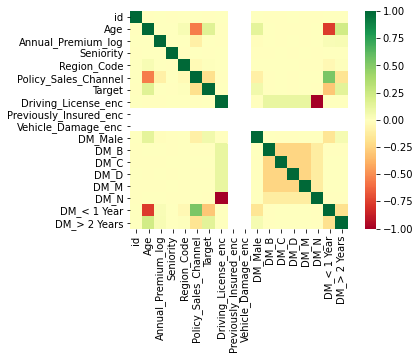

In [ ]:
sns.heatmap(data_encoded.corr(), square= True, cmap='RdYlGn')

In [9]:
data_encoded.drop(['DM_N'], inplace=True, axis=1)

In [ ]:
data_encoded.columns

Index(['id', 'Age', 'Annual_Premium_log', 'Seniority', 'Region_Code',
       'Policy_Sales_Channel', 'Target', 'Driving_License_enc',
       'Previously_Insured_enc', 'Vehicle_Damage_enc', 'DM_Male', 'DM_B',
       'DM_C', 'DM_D', 'DM_M', 'DM_< 1 Year', 'DM_> 2 Years'],
      dtype='object')

*  Target Encoder for Region_Code and Policy_Sales_Channel columns

In [10]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values


def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=2424, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values


def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

## **Training and Validation Split**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:417

Data train shape:  (81880, 15)
Data test shape:  (81880,)


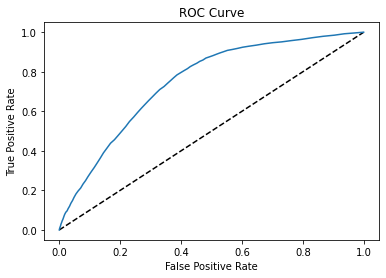

F1_score:  0.47234678624813153
Accuracy_score:  0.7068535977724586
AUC: 0.7472901371483974
              precision    recall  f1-score   support

           0       0.76      0.84      0.80     13963
           1       0.55      0.41      0.47      6508

    accuracy                           0.71     20471
   macro avg       0.65      0.63      0.63     20471
weighted avg       0.69      0.71      0.69     20471



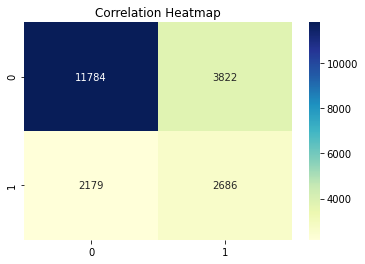

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:417

Data train shape:  (81881, 15)
Data test shape:  (81881,)


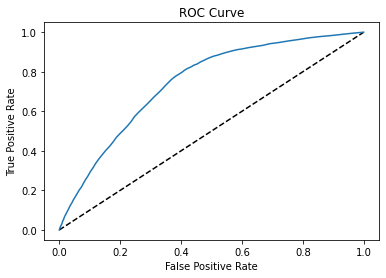

F1_score:  0.46127428829643013
Accuracy_score:  0.7087933561309233
AUC: 0.744261230697135
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     14094
           1       0.54      0.40      0.46      6376

    accuracy                           0.71     20470
   macro avg       0.65      0.62      0.63     20470
weighted avg       0.69      0.71      0.69     20470



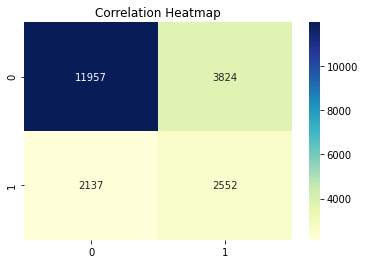

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:417

Data train shape:  (81881, 15)
Data test shape:  (81881,)


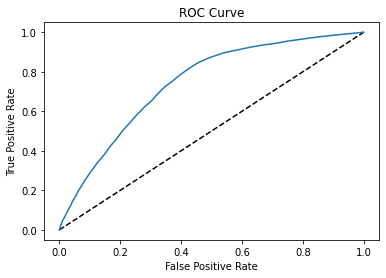

F1_score:  0.4571479059904577
Accuracy_score:  0.6998534440644846
AUC: 0.7425912778053279
              precision    recall  f1-score   support

           0       0.74      0.85      0.79     13853
           1       0.55      0.39      0.46      6617

    accuracy                           0.70     20470
   macro avg       0.65      0.62      0.62     20470
weighted avg       0.68      0.70      0.68     20470



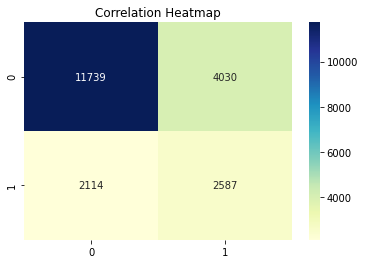

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:417

Data train shape:  (81881, 15)
Data test shape:  (81881,)


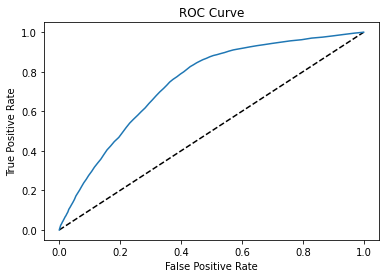

F1_score:  0.4647464216292631
Accuracy_score:  0.7040547142159257
AUC: 0.7421128403436799
              precision    recall  f1-score   support

           0       0.75      0.84      0.80     13975
           1       0.55      0.40      0.46      6495

    accuracy                           0.70     20470
   macro avg       0.65      0.62      0.63     20470
weighted avg       0.69      0.70      0.69     20470



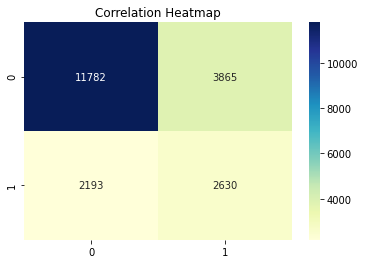

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:417

Data train shape:  (81881, 15)
Data test shape:  (81881,)


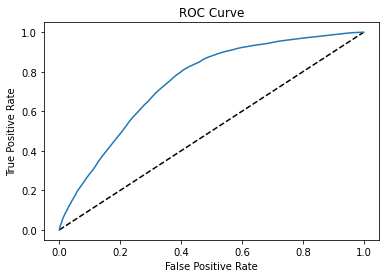

F1_score:  0.4700847235566425
Accuracy_score:  0.7036150464093796
AUC: 0.7483643341333651
              precision    recall  f1-score   support

           0       0.76      0.84      0.79     13993
           1       0.54      0.42      0.47      6477

    accuracy                           0.70     20470
   macro avg       0.65      0.63      0.63     20470
weighted avg       0.69      0.70      0.69     20470



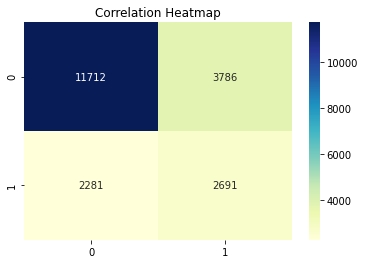

In [16]:
# Create 5-fold cross-validation
kf = KFold(n_splits=5, random_state=24, shuffle=True)

Region_Code_list=[]
Policy_Sales_Channel_list=[]
roc_auc_score_list=[]

# For each folds split
for train_index, test_index in kf.split(data_encoded):
    cv_train, cv_test = data_encoded.iloc[train_index], data_encoded.iloc[test_index]

    # Create mean target encoded feature
    cv_train['Region_Code_enc'], cv_test['Region_Code_enc'] = mean_target_encoding(train=cv_train,
                                                                           test=cv_test,
                                                                           target='Target',
                                                                           categorical='Region_Code',
                                                                           alpha=5)
    cv_train['Policy_Sales_Channel_enc'], cv_test['Policy_Sales_Channel_enc'] = mean_target_encoding(train=cv_train,
                                                                           test=cv_test,
                                                                           target='Target',
                                                                           categorical='Policy_Sales_Channel',
                                                                           alpha=5)
    
    # Take the average of encoded values for each category (columns Region_Code and Policy_Sales_Channel)
    train_enc_RC= pd.DataFrame(cv_train.groupby('Region_Code')['Region_Code_enc'].mean().reset_index(), 
                               columns=['Region_Code', 'Region_Code_enc'])
    test_enc_RC=pd.DataFrame(cv_test.groupby('Region_Code')['Region_Code_enc'].mean().reset_index(), 
                             columns=['Region_Code', 'Region_Code_enc'])
    #print(train_enc_RC.head())

    Region_Code_list += [ [key, value] for key, value in zip(train_enc_RC.Region_Code, train_enc_RC.Region_Code_enc)]
    Region_Code_list += [ [key, value] for key, value in zip(test_enc_RC.Region_Code, test_enc_RC.Region_Code_enc)]
    #print(Region_Code_list[:10])

    train_enc_PSL= pd.DataFrame(cv_train.groupby('Policy_Sales_Channel')['Policy_Sales_Channel_enc'].mean().reset_index(), 
                                columns=['Policy_Sales_Channel', 'Policy_Sales_Channel_enc'])
    test_enc_PSL=pd.DataFrame(cv_test.groupby('Policy_Sales_Channel')['Policy_Sales_Channel_enc'].mean().reset_index(), 
                             columns=['Policy_Sales_Channel', 'Policy_Sales_Channel_enc'])

    Policy_Sales_Channel_list += [ [key, value] for key, value in zip(train_enc_PSL.Policy_Sales_Channel, train_enc_PSL.Policy_Sales_Channel_enc)]
    Policy_Sales_Channel_list += [ [key, value] for key, value in zip(test_enc_PSL.Policy_Sales_Channel, test_enc_PSL.Policy_Sales_Channel_enc)]
    #print(cv_train[['Region_Code', 'Target', 'Region_Code_enc']].sample(n=1))

    cv_train.drop(['Region_Code','id','Policy_Sales_Channel'], inplace=True, axis=1)
    cv_test.drop(['Region_Code','id','Policy_Sales_Channel'], inplace=True, axis=1)
    #print(cv_train.columns)


    features=['Age', 'Annual_Premium_log', 'Seniority',
       'Driving_License_enc', 'Previously_Insured_enc', 'Vehicle_Damage_enc',
       'DM_Male', 'DM_B', 'DM_C', 'DM_D', 'DM_M', 'DM_< 1 Year',
       'DM_> 2 Years', 'Region_Code_enc', 'Policy_Sales_Channel_enc'] 



    #Training
    X_train, y_train=cv_train[features],cv_train[['Target']]
    X_test, y_test=cv_test[features],cv_test[['Target']]
    
    #Dimensionality Reduction with PCA

    #pca = PCA(n_components=.98)  #n_components=9
    #pca.fit(X_train)

    #plt.plot(pca.explained_variance_ratio_)
    #plt.xlabel('Principal component index')
    #plt.ylabel('Explained Variance Ratio')
    #plt.show()

    #X_train_pca = pd.DataFrame(pca.transform(X_train))
    #X_test_pca = pd.DataFrame(pca.transform(X_test))
    
    #print("Dataset shape before PCA: ", X_train.shape)
    #print("Dataset shape after PCA: ", X_train_pca.shape)

    print('Data train shape: ', X_train.shape)
    print('Data test shape: ', y_train.values.ravel().shape)


    param_grid_logreg={'C':list(range(5,60,1))}
    #param_grid_logreg={'C':list(range(50,150,10))}
    #param_grid_xgb={'n_estimators':list(range(60,100,2)), 'learning_rate': np.arange(.15, .25, .01),  'subsample': np.arange(.8, 1.01, .04)}

    #RandomSearch and Model Selection

    #random_class=RandomizedSearchCV(estimator=LogisticRegression(), param_distributions=param_grid_logreg,
    #                                 n_iter=10, scoring='f1',
    #                                 refit=True, return_train_score=True)

    
    #random_class= LogisticRegression(C=50) #.7487
    #random_class= KNeighborsClassifier() #.68
    random_class=RandomForestClassifier() #.7453
    #random_class=RFE(estimator=RandomForestClassifier(), n_features_to_select=12, verbose =1) #.7470
    #random_class= SGDClassifier(loss='log') #.7463
    #random_class= xgb.XGBClassifier(objective='binary:logistic',random_state=123, n_estimators=85, learning_rate=.2, subsample=.85) #.76

    random_class.fit(X_train.values, y_train.values.ravel())
    #print('Best parameters: ',random_class.best_params_)
    #print('Best f1_score: ',random_class.best_score_)
    
    #best_est=random_class.best_estimator_
    best_est=random_class


    #Evaluation
    y_pred= best_est.predict(X_test.values) 
    y_pred_proba=  best_est.predict_proba(X_test.values)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_proba)
    
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    print('F1_score: ',f1_score(y_test.values, y_pred))
    print('Accuracy_score: ',accuracy_score(y_test.values, y_pred))

    score=roc_auc_score(y_test.values, y_pred_proba)
    roc_auc_score_list.append(score) 

    print("AUC: {}".format(score))
    print(classification_report(y_test, y_pred))
    corr=confusion_matrix(y_pred, y_test)
     
    heatmap=sns.heatmap(corr, annot=True, fmt="d", cmap="YlGnBu")
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12})
    
    plt.show()
    print('')
    print('')


    
          

In [ ]:
print("Average_AUC: {}".format(np.mean(roc_auc_score_list)))

Average_AUC: 0.7487675365459696


In [ ]:
#Extract the mean for each category
RC_dict_count=dict.fromkeys(data_categorical.Region_Code.unique(), 0)
RC_dict_sum=dict.fromkeys(data_categorical.Region_Code.unique(), 0)
RC_dict_enc=dict.fromkeys(data_categorical.Region_Code.unique(), 0)

for row in Region_Code_list:
  region_code, region_code_enc=row[0], row[1]
  RC_dict_count[region_code]+=1
  RC_dict_sum[region_code]+=region_code_enc

for key, value in RC_dict_count.items():
  RC_dict_enc[key]= RC_dict_sum[key]/value



PSL_dict_count=dict.fromkeys(data_categorical.Policy_Sales_Channel.unique(), 0)
PSL_dict_sum=dict.fromkeys(data_categorical.Policy_Sales_Channel.unique(), 0)
PSL_dict_enc=dict.fromkeys(data_categorical.Policy_Sales_Channel.unique(), 0)

for row in Policy_Sales_Channel_list:
  policy_sales_channel, policy_sales_channel_enc=row[0], row[1]
  PSL_dict_count[policy_sales_channel]+=1
  PSL_dict_sum[policy_sales_channel]+=policy_sales_channel_enc

for key, value in PSL_dict_count.items():
  PSL_dict_enc[key]= PSL_dict_sum[key]/value  


RC_keys_train= set(RC_dict_enc.keys())
PSL_keys_train= set(PSL_dict_enc.keys()) 

## **Processing test data**

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cross_Sale_Classification/prediction_independent.csv')
df.head()

,id,Gender,Age,Driving_License,Licence_Type,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Seniority
0,1,Male,51,1,M,28,No,1-2 Year,Yes,45301,26,31
1,2,Male,63,1,B,39,No,1-2 Year,Yes,18609,124,28
2,3,Male,76,1,M,38,No,1-2 Year,Yes,35081,26,164
3,4,Female,38,1,B,41,No,1-2 Year,Yes,19603,124,33
4,5,Female,21,1,D,30,Yes,< 1 Year,No,27842,160,28


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45196 entries, 0 to 45195
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    45196 non-null  int64 
 1   Gender                45196 non-null  object
 2   Age                   45196 non-null  int64 
 3   Driving_License       45196 non-null  int64 
 4   Licence_Type          42921 non-null  object
 5   Region_Code           45196 non-null  int64 
 6   Previously_Insured    45196 non-null  object
 7   Vehicle_Age           45196 non-null  object
 8   Vehicle_Damage        45196 non-null  object
 9   Annual_Premium        45196 non-null  int64 
 10  Policy_Sales_Channel  45196 non-null  int64 
 11  Seniority             45196 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 4.1+ MB


In [ ]:
df.fillna({'Licence_Type':'N'}, inplace=True)

df['Previously_Insured'].replace({'Yes':'True','No':'False'}, inplace=True)
df['Vehicle_Damage'].replace({'Yes':'True','No':'False'}, inplace=True)

df[labels_multi]=df[labels_multi].apply(lambda x: x.astype('category') ,axis=0)
df[labels_bin]=df[labels_bin].apply(lambda x: x.astype('bool') ,axis=0)

df_categorical=df[['Gender', 'Driving_License', 'Licence_Type', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
       'Policy_Sales_Channel']]
df_numerical=df[['id','Age', 'Annual_Premium', 'Seniority']]

df_categorical['Driving_License_enc']=enc1.transform(df_categorical.Driving_License)
df_categorical['Previously_Insured_enc']=enc2.transform(df_categorical.Previously_Insured)
df_categorical['Vehicle_Damage_enc']=enc3.transform(df_categorical.Vehicle_Damage)

df_categorical.drop(['Driving_License','Previously_Insured','Vehicle_Damage'], axis=1, inplace=True)

df_categorical=pd.get_dummies(df_categorical, columns=['Gender', 'Licence_Type', 'Vehicle_Age'], drop_first=True, prefix='DM')

df_numerical['Annual_Premium_log']=np.log(df_numerical.Annual_Premium)
df_num_scaled=pd.concat([pd.DataFrame(ss1.transform(df_numerical[['Age']]), columns=['Age']), 
                           pd.DataFrame(ss2.transform(df_numerical[['Annual_Premium_log']]), columns=['Annual_Premium_log']), 
                           pd.DataFrame(ss3.transform(df_numerical[['Seniority']]), columns=['Seniority']) ], axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [ ]:
RC_keys_test= set(df_categorical.Region_Code.value_counts().index)
PSL_keys_test=set(df_categorical.Policy_Sales_Channel.value_counts().index)

print(RC_keys_test.difference(RC_keys_train))
print(PSL_keys_test.difference(PSL_keys_train)) #New Policy Channels Sales

set()
{33, 34, 102, 43, 112, 83, 27, 126, 95}


In [ ]:
for key in PSL_keys_test.difference(PSL_keys_train):
  PSL_dict_enc[key]=np.mean(list(PSL_dict_enc.values()))

df_categorical['Region_Code_enc']=df_categorical.Region_Code.replace(RC_dict_enc)
df_categorical['Policy_Sales_Channel_enc']=df_categorical.Policy_Sales_Channel.replace(PSL_dict_enc)

In [ ]:
df_encoded=pd.concat([df_numerical.id, df_num_scaled, df_categorical], axis=1)
df_encoded.drop(['DM_N','Region_Code','Policy_Sales_Channel'], inplace=True, axis=1)

In [ ]:
df_encoded.shape

(45196, 16)

## **Model Evaluation**

In [ ]:
features=['Age', 'Annual_Premium_log', 'Seniority',
       'Driving_License_enc', 'Previously_Insured_enc', 'Vehicle_Damage_enc',
       'DM_Male', 'DM_B', 'DM_C', 'DM_D', 'DM_M', 'DM_< 1 Year',
       'DM_> 2 Years', 'Region_Code_enc', 'Policy_Sales_Channel_enc'] 

#Testing
X_test=df_encoded[features]
print(X_test.shape)

y_pred=logreg.predict(X_test)
y_pred_proba= logreg.predict_proba(X_test)[:,1]
print(y_pred.shape)


(45196, 15)
(45196,)


In [ ]:
predictions_test=pd.concat([df.id, pd.DataFrame(y_pred.reshape(-1,1), columns=['prediction'])], axis=1).set_index('id')
predictions_test.to_csv('predictions_test.csv')

In [ ]:
print("AUC: {}".format(roc_auc_score(y_test, y_pred_proba)))